In [1]:
from local_vars import root_folder

data_folder = r"Circles"
batch_size = 10
image_size = 64
input_image_size = 128

In [2]:
import pandas as pd
import numpy as np
import itertools
import os
import keras

from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.utils import Sequence

from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from skimage.io import imread
from skimage.transform import resize

Using TensorFlow backend.


In [3]:
data_fullpath = os.path.join(root_folder, data_folder)
train_fullpath = os.path.join(data_fullpath, "train")
valid_fullpath = os.path.join(data_fullpath, "valid")
test_fullpath = os.path.join(data_fullpath, "test")

print("Training data folder:   {}".format(train_fullpath))
print("Validation data folder: {}".format(valid_fullpath))
print("Test data folder:       {}".format(test_fullpath))

Training data folder:   c:\Temp\Circles\train
Validation data folder: c:\Temp\Circles\valid
Test data folder:       c:\Temp\Circles\test


In [4]:
train_annotations_df = pd.DataFrame()

num_csv_files = 0
for file_name in os.listdir(train_fullpath):
    if not file_name.endswith(".csv"):
        continue
    num_csv_files += 1
    current_file_path = os.path.join(train_fullpath, file_name)
    train_annotations_df = pd.concat([train_annotations_df, pd.read_csv(current_file_path)])

valid_annotations_df = pd.DataFrame()

for file_name in os.listdir(valid_fullpath):
    if not file_name.endswith(".csv"):
        continue
    num_csv_files += 1
    current_file_path = os.path.join(valid_fullpath, file_name)
    valid_annotations_df = pd.concat([valid_annotations_df, pd.read_csv(current_file_path)])

test_annotations_df = pd.DataFrame()

for file_name in os.listdir(test_fullpath):
    if not file_name.endswith(".csv"):
        continue
    num_csv_files += 1
    current_file_path = os.path.join(test_fullpath, file_name)
    test_annotations_df = pd.concat([test_annotations_df, pd.read_csv(current_file_path)])

num_test_images = test_annotations_df.shape[0]
    
print("Number of training images:   {}".format(train_annotations_df.shape[0]))
print("Number of validation images: {}".format(valid_annotations_df.shape[0]))
print("Number of test images:       {}".format(num_test_images))

Number of training images:   10000
Number of validation images: 100
Number of test images:       100


In [5]:
class MyBatchGenerator(Sequence):
    
    def __init__(self, image_filenames, annotations_df, batch_size, image_size=256):
        self.image_filenames, self.annotations_df = image_filenames, annotations_df
        self.batch_size = batch_size
    
    def __len__(self):
        num_batches = np.ceil(len(self.image_filenames) / float(self.batch_size))
        return int(num_batches)
    
    def __getitem__(self, idx):
        from_index = idx * self.batch_size
        to_index = (idx + 1) * self.batch_size
        batch_x = self.image_filenames[from_index:to_index]
        batch_y = self.annotations_df[['x_position', 'y_position']].iloc[from_index:to_index]
        batch_y = batch_y / float(input_image_size)
        return np.array([
            resize(
                imread(file_name).astype(np.uint8),
                (image_size, image_size, 1),
                anti_aliasing=False,
                preserve_range=True,
                mode='constant') for file_name in batch_x]),  np.array(batch_y)

In [6]:
train_image_filenames = [os.path.join(train_fullpath,fn) for fn in os.listdir(train_fullpath) if fn.endswith('png')]
valid_image_filenames = [os.path.join(valid_fullpath,fn) for fn in os.listdir(valid_fullpath) if fn.endswith('png')]
test_image_filenames = [os.path.join(test_fullpath,fn) for fn in os.listdir(test_fullpath) if fn.endswith('png')]

In [7]:
train_generator = MyBatchGenerator(train_image_filenames, train_annotations_df, batch_size, image_size)
valid_generator = MyBatchGenerator(valid_image_filenames, valid_annotations_df, batch_size, image_size)

<class 'numpy.float64'>


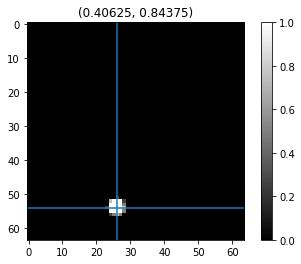

In [8]:
x, y = valid_generator.__getitem__(0)

plt.title(str((y[0][0], y[0][1])))
plt.imshow(x[0][:,:,0], cmap='gray')
plt.axvline(x=y[0][0] * image_size)
plt.axhline(y=y[0][1] * image_size)
out = plt.colorbar()

print(type(x[0][0,0,0]))

In [9]:
model = Sequential()

model.add(Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=(image_size, image_size, 1)))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.2))

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.2))

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 8)         80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 16)        0         
__________

In [10]:
num_epochs = 8
num_validation_steps = valid_annotations_df.shape[0] // batch_size
num_steps = train_annotations_df.shape[0] // batch_size

print("Training steps:   {}".format(num_steps))
print("Validation steps: {}".format(num_validation_steps))

Training steps:   1000
Validation steps: 10


In [11]:
model.compile(Adam(lr=.0001), loss='mse', metrics=['accuracy'])

In [12]:
history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=num_steps,
    epochs=num_epochs,
    verbose=1,
    validation_data=valid_generator,
    validation_steps=num_validation_steps)

Epoch 1/8
1000/1000 [==============================] - 21s 21ms/step - loss: 0.0107 - acc: 0.9379 - val_loss: 0.0030 - val_acc: 0.9600
Epoch 2/8
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0029 - acc: 0.9571 - val_loss: 0.0025 - val_acc: 0.9900
Epoch 3/8
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0019 - acc: 0.9664 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 4/8
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0014 - acc: 0.9737 - val_loss: 0.0014 - val_acc: 0.9900
Epoch 5/8
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0011 - acc: 0.9750 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 6/8
1000/1000 [==============================] - 10s 10ms/step - loss: 8.9029e-04 - acc: 0.9759 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 7/8
1000/1000 [==============================] - 10s 10ms/step - loss: 6.9882e-04 - acc: 0.9768 - val_loss: 8.4878e-04 - val_acc: 1.0000
Epoch 8/8
1000/1000 [======================

Text(0.5,1,'Accuracy Curves')

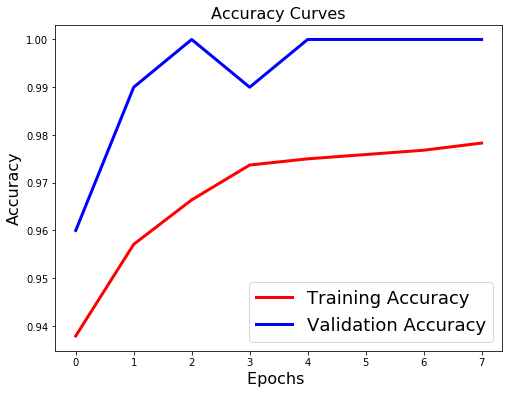

In [13]:
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [14]:
test_generator = MyBatchGenerator(test_image_filenames, test_annotations_df, num_test_images, image_size)

In [15]:
def plots(ims, ys, figsize=(20,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis("Off")
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i][:, :, 0], cmap='gray')
        plt.axvline(x=ys[i][0] * image_size)
        plt.axhline(y=ys[i][1] * image_size)

Average error: 0.0450


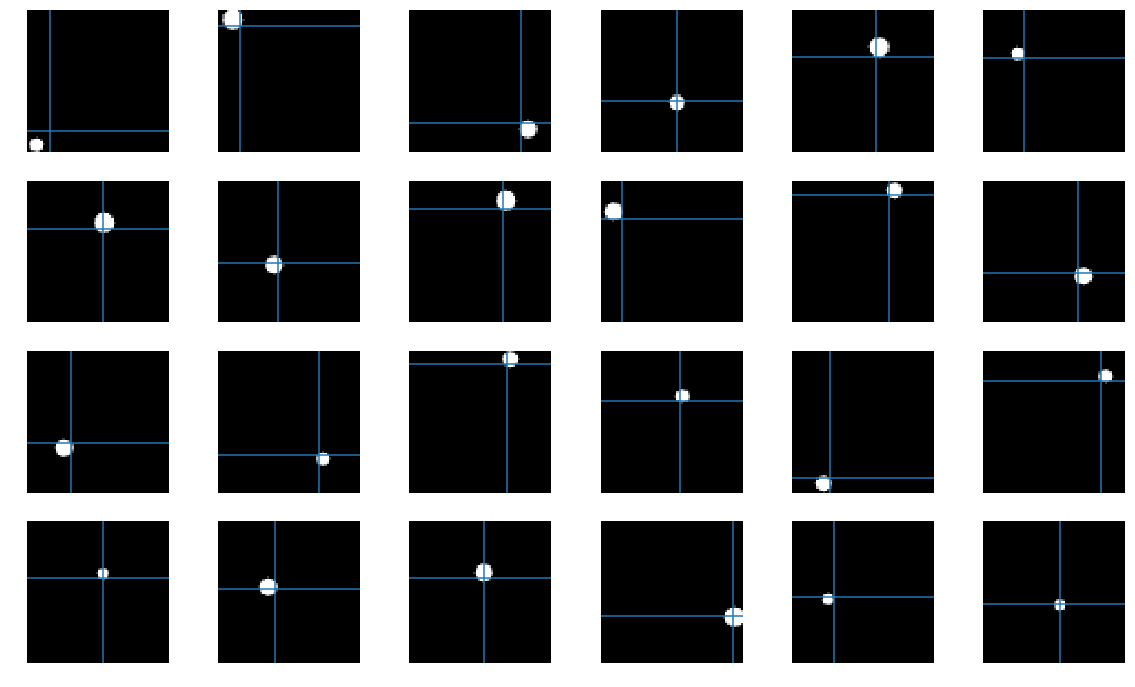

In [20]:
x, y = test_generator.__getitem__(0)
y_pred = model.predict(x)

n = len(y)
average_error = 0.0
averaging_factor = 1.0 / n
for i in range(len(y)):
    distance = np.linalg.norm(y[i] - y_pred[i])
    average_error += distance * averaging_factor

print("Average error: {0:.4f}".format(average_error))    

plots(x[:24], y_pred[:24], figsize=(20,12), rows=4)

In [17]:
import datetime

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

weights_folder = os.path.join(root_folder, "weights")

if not os.path.exists(weights_folder):
    os.makedirs(weights_folder)
    print("Creating folder: {}".format(weights_folder))

weights_file_name = "weights_" + timestamp + ".h5"
weights_file_path = os.path.join(weights_folder, weights_file_name)

model.save_weights(weights_file_path)